# Оценка линейного искажающего оператора в задаче восстановления изображений
Время работы: очень долго(больше часа)

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
# import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage.measure import compare_psnr
from functools import partial
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm_notebook
import pickle
import os.path

from util import *
from richardson_lucy import *
plt.gray()

In [2]:
astro = color.rgb2gray(data.astronaut())
liftingbody = img_as_float(io.imread('liftingbody.png'))

In [3]:
iterations=20

## Оценка криволинейного оператора смаза, представленного кривой Безье

[15, 4, 20, 20]


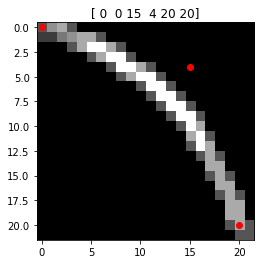

In [4]:
sz = 21
deg = 5
points_real = [(deg-1)*sz//deg-1, sz//deg, sz-1, sz-1]
print(points_real)
psf_bezier = bezier_psf2(points_real, 100)
plt.imshow(psf_bezier)
plt.title(np.concatenate(([0,0], points_real)))
plt.plot(0, 0, 'ro')
plt.plot(points_real[0], points_real[1], 'ro')
plt.plot(points_real[2], points_real[3], 'ro')
plt.savefig("pic/curved-psf.png")
plt.show()

In [5]:
lifting_bezier_blurred = convolve2d(liftingbody, psf_bezier, 'same')
#lifting_bezier_blurred = edgetaper(lifting_bezier_blurred, gkern2(41,10))

In [6]:
lifting_restored = restoration.richardson_lucy(lifting_bezier_blurred, psf_bezier, iterations=iterations)
psnr_py = compare_psnr_crop(liftingbody, lifting_restored)

deconv_bezier = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, clip=True, useFFT=True, dampar=0.004)
psnr_my = compare_psnr_crop(liftingbody, deconv_bezier['image'])

/home/progiv/dev/lucy_richardson/scikit-image/skimage/restoration/deconvolution.py:389: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = image / convolve_method(im_deconv, psf, 'same')
/home/progiv/dev/lucy_richardson/scikit-image/skimage/restoration/deconvolution.py:393: RuntimeWarning: invalid value encountered in greater
  im_deconv[im_deconv > 1] = 1
/home/progiv/dev/lucy_richardson/scikit-image/skimage/restoration/deconvolution.py:394: RuntimeWarning: invalid value encountered in less
  im_deconv[im_deconv < -1] = -1


/home/progiv/.local/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/progiv/.local/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


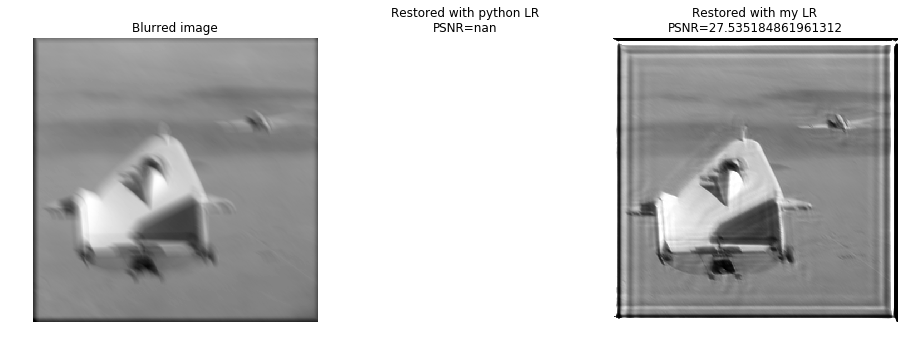

In [7]:
show_results(lifting_bezier_blurred, lifting_restored, deconv_bezier['image'],
            titles=['Blurred image', 'Restored with python LR\nPSNR={0}'.format(psnr_py), 'Restored with my LR\nPSNR={0}'.format(psnr_my)])

### Кепстр

In [8]:
s_n, S_find = find_noise(lifting_bezier_blurred)
print(s_n, S_find)

7.267261165382173e-05 3.921113183461706e-07


In [9]:
#N,M = lifting_bezier_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.real(np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_bezier_blurred)))))
#K_shift = K
K_shift = np.fft.fftshift(K)

In [10]:
c,r = np.unravel_index(np.argmin(K_shift, axis=None), K_shift.shape)
nn = np.argmin(np.real(K_shift))
n, m, = K_shift.shape
x2 = np.array([r - n//2, c - m//2])
if x2[0]<0:
    x2 = -x2
x1 = x2/2 + np.array([2,-2])
print(x2)

[20 21]


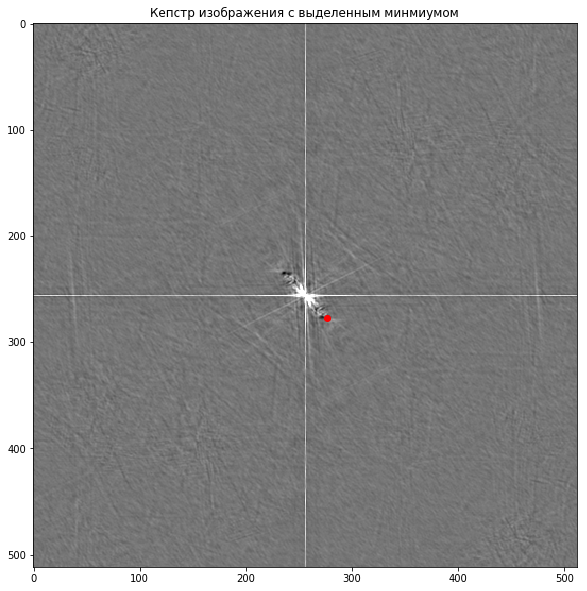

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(np.real(K_shift),-1,1))#, vmin=noisy.min(), vmax=noisy.max())
plt.plot(m//2 + x2[0], n//2 + x2[1], 'ro')
plt.title('Кепстр изображения с выделенным минмиумом')
plt.savefig('pic/kepstr.png')
plt.show()

In [12]:
x0 = np.concatenate((x1, x2))
print(x0)

[12.   8.5 20.  21. ]


### Минимизация

In [13]:
def funcToMinimizeCurved(xy, I_blurred, crop=100, *args, **kwargs):
    print(xy)
    psf = bezier_psf2(xy, n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = fftconvolve(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))
#partial(funcToMinimizeCurved, I_blurred=lifting_bezier_blurred, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True)([0, 10, 10, 10])

In [14]:
def funcToMinimizeCurved2(xy, I_blurred, xy2, crop=100, *args, **kwargs):
    psf = bezier_psf2(np.concatenate((np.array(xy), np.array(xy2))))
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [15]:
f = partial(funcToMinimizeCurved2, I_blurred=lifting_bezier_blurred, xy2=x2, iterations=iterations, eps=1e-5, dampar=10*s_n, clip=True, useFFT=True)

Scale=2 => 1 час <img src='pic/optimization_useless_x2.png'>
Scale=4 => 5 часов <img src='pic/optimization_useless_x4.png'>

In [16]:
pickle_filename = "matrix4.pickle"

if os.path.isfile(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        a = pickle.load(f)
else:
    scale = 4
    a = np.ones((scale*x2[1], scale*x2[0]))
    for yy in tqdm_notebook(range(scale*x2[1])):
        for xx in range(scale*x2[0]):
            val = f(np.array([xx/scale,yy/scale]))
            print(yy/scale, xx/scale, val)
            a[yy,xx] = val
    with open(pickle_filename, 'wb') as a_file:
        pickle.dump(astro, a_file)

HBox(children=(IntProgress(value=0, max=84), HTML(value='')))

0.0 0.0 5.3903175223358916e-05
0.0 0.25 5.8727041786189575e-05
0.0 0.5 4.945895541648942e-05
0.0 0.75 4.490313007278311e-05
0.0 1.0 5.7643292277156914e-05
0.0 1.25 6.093653821640951e-05
0.0 1.5 5.761942242275114e-05
0.0 1.75 5.503541943345913e-05
0.0 2.0 5.225163434769573e-05
0.0 2.25 5.675180330248666e-05
0.0 2.5 5.675641224381217e-05
0.0 2.75 5.993797641357264e-05
0.0 3.0 3.686430373916708e-05
0.0 3.25 4.338605020336007e-05
0.0 3.5 5.627060929745253e-05
0.0 3.75 4.794440220496916e-05
0.0 4.0 5.26713462100486e-05
0.0 4.25 5.334948866169413e-05
0.0 4.5 5.276294899993061e-05
0.0 4.75 5.40900947673977e-05
0.0 5.0 5.1934752114511006e-05
0.0 5.25 4.918476579353033e-05
0.0 5.5 4.8624866573849104e-05
0.0 5.75 4.5318657514081154e-05
0.0 6.0 4.191499789785409e-05
0.0 6.25 4.5360653687989995e-05
0.0 6.5 5.138913337156558e-05
0.0 6.75 4.8656505547653805e-05
0.0 7.0 3.675688629843306e-05
0.0 7.25 4.0614670626484494e-05
0.0 7.5 3.918928885190868e-05
0.0 7.75 3.362610043923057e-05
0.0 8.0 3.0623558

0.75 4.75 4.3352928748992515e-05
0.75 5.0 5.510209651367213e-05
0.75 5.25 5.477043257992862e-05
0.75 5.5 4.674740575514998e-05
0.75 5.75 4.688219658277459e-05
0.75 6.0 4.841760047725089e-05
0.75 6.25 4.075476638390859e-05
0.75 6.5 3.851309617438809e-05
0.75 6.75 3.688174344571994e-05
0.75 7.0 4.30115721924838e-05
0.75 7.25 4.670307882257326e-05
0.75 7.5 4.5409742039136325e-05
0.75 7.75 4.1337473481564334e-05
0.75 8.0 4.7221858995344216e-05
0.75 8.25 4.1244810708123334e-05
0.75 8.5 3.501648955420085e-05
0.75 8.75 3.501648955420085e-05
0.75 9.0 3.332840105425085e-05
0.75 9.25 4.1479945278965e-05
0.75 9.5 4.0533466699405683e-05
0.75 9.75 4.165569539882202e-05
0.75 10.0 3.4493224362683336e-05
0.75 10.25 2.220265372865592e-05
0.75 10.5 2.494874361178886e-05
0.75 10.75 2.3174352778678847e-05
0.75 11.0 2.367746254687615e-05
0.75 11.25 3.369456535918463e-05
0.75 11.5 2.6926273514800702e-05
0.75 11.75 2.9556849221982943e-05
0.75 12.0 3.3630064284230955e-05
0.75 12.25 2.3165339908042616e-05
0.75

1.5 9.0 3.2242198340012065e-05
1.5 9.25 3.0935513201344676e-05
1.5 9.5 3.481100444152637e-05
1.5 9.75 3.373736766836094e-05
1.5 10.0 4.6044087070578566e-05
1.5 10.25 2.7576042808218882e-05
1.5 10.5 2.4507947664185952e-05
1.5 10.75 2.6801900751894235e-05
1.5 11.0 2.39980241664141e-05
1.5 11.25 2.2741811289987377e-05
1.5 11.5 1.9284761479387094e-05
1.5 11.75 2.1867414491826443e-05
1.5 12.0 3.81525065318224e-05
1.5 12.25 3.4960899380512926e-05
1.5 12.5 3.12234965912683e-05
1.5 12.75 2.0015223391166975e-05
1.5 13.0 2.0848933382415108e-05
1.5 13.25 2.115864641657636e-05
1.5 13.5 2.314608367986193e-05
1.5 13.75 1.997338459873349e-05
1.5 14.0 3.0180143157925214e-05
1.5 14.25 2.417995851979261e-05
1.5 14.5 1.948637176023215e-05
1.5 14.75 1.7766953187789054e-05
1.5 15.0 1.8130231851770436e-05
1.5 15.25 2.1490417704015147e-05
1.5 15.5 1.8267453591408415e-05
1.5 15.75 1.6958579810718046e-05
1.5 16.0 1.739585134581504e-05
1.5 16.25 1.9792295985730388e-05
1.5 16.5 2.135189189131437e-05
1.5 16.75 1.

2.25 13.25 2.85583959812497e-05
2.25 13.5 1.992558667585743e-05
2.25 13.75 2.1279872145473534e-05
2.25 14.0 1.9340925926207168e-05
2.25 14.25 2.3295770717877404e-05
2.25 14.5 2.3295770717877404e-05
2.25 14.75 2.351249904121603e-05
2.25 15.0 3.191157698097239e-05
2.25 15.25 1.981667365264131e-05
2.25 15.5 1.848304182424528e-05
2.25 15.75 1.9282764082921296e-05
2.25 16.0 2.1523592252519793e-05
2.25 16.25 1.6060374669770742e-05
2.25 16.5 1.5597755741033782e-05
2.25 16.75 2.5225660962317308e-05
2.25 17.0 2.248966752170493e-05
2.25 17.25 1.8206140998387026e-05
2.25 17.5 1.637241499514617e-05
2.25 17.75 1.2909780871342052e-05
2.25 18.0 1.64470333889964e-05
2.25 18.25 1.5783318941676574e-05
2.25 18.5 1.5783318941676574e-05
2.25 18.75 1.7665540168020235e-05
2.25 19.0 2.2155693859265373e-05
2.25 19.25 1.9628070769433868e-05
2.25 19.5 1.41896191312991e-05
2.25 19.75 1.2522651613838828e-05
2.5 0.0 5.3820279023863886e-05
2.5 0.25 5.416011000185542e-05
2.5 0.5 5.3532912187472945e-05
2.5 0.75 5.3608

3.0 17.5 2.1889935339517694e-05
3.0 17.75 2.486805978506113e-05
3.0 18.0 1.9031548890994052e-05
3.0 18.25 1.627204361574001e-05
3.0 18.5 1.5701834550143694e-05
3.0 18.75 1.2688697524384326e-05
3.0 19.0 1.3880303643950696e-05
3.0 19.25 1.2468906617082774e-05
3.0 19.5 1.5051965065182518e-05
3.0 19.75 1.7682355268886725e-05
3.25 0.0 5.3738985115498676e-05
3.25 0.25 5.169469659102731e-05
3.25 0.5 5.3820279023863886e-05
3.25 0.75 5.774928838837361e-05
3.25 1.0 5.409396158575649e-05
3.25 1.25 6.000839594044109e-05
3.25 1.5 5.836041946973742e-05
3.25 1.75 5.242732427564048e-05
3.25 2.0 3.709030460424935e-05
3.25 2.25 2.761836123476342e-05
3.25 2.5 3.943465431093372e-05
3.25 2.75 5.109377702531097e-05
3.25 3.0 5.2590855473284526e-05
3.25 3.25 5.3188993522862084e-05
3.25 3.5 3.599924644355984e-05
3.25 3.75 3.940872978520548e-05
3.25 4.0 5.199911091107185e-05
3.25 4.25 7.33399502497295e-05
3.25 4.5 6.623348457609625e-05
3.25 4.75 5.5235077240481334e-05
3.25 5.0 5.2491079443677774e-05
3.25 5.25 4

4.0 1.5 5.416011000185542e-05
4.0 1.75 5.3532912187472945e-05
4.0 2.0 5.1901716439053655e-05
4.0 2.25 5.1632029631786936e-05
4.0 2.5 5.7080792539132556e-05
4.0 2.75 4.10341453204467e-05
4.0 3.0 2.7032584167654443e-05
4.0 3.25 4.170452727194391e-05
4.0 3.5 5.3572260809705146e-05
4.0 3.75 5.3572260809705146e-05
4.0 4.0 5.6924784330723307e-05
4.0 4.25 4.3904195510948406e-05
4.0 4.5 5.078955393748976e-05
4.0 4.75 6.131796917860707e-05
4.0 5.0 6.623348457609625e-05
4.0 5.25 5.992591749483879e-05
4.0 5.5 4.914067180899089e-05
4.0 5.75 4.914067180899089e-05
4.0 6.0 4.914067180899089e-05
4.0 6.25 5.578401812948645e-05
4.0 6.5 4.75287188746448e-05
4.0 6.75 5.259056556508797e-05
4.0 7.0 4.92586050592202e-05
4.0 7.25 4.837257875054558e-05
4.0 7.5 4.269083138985271e-05
4.0 7.75 4.269083138985271e-05
4.0 8.0 4.180712783292211e-05
4.0 8.25 4.631454658806968e-05
4.0 8.5 4.7451129682691516e-05
4.0 8.75 4.5491035721805575e-05
4.0 9.0 3.7106375867379884e-05
4.0 9.25 3.772776890183602e-05
4.0 9.5 3.57182

4.75 6.0 5.0687682325806754e-05
4.75 6.25 4.8919788007097885e-05
4.75 6.5 4.49959681856726e-05
4.75 6.75 4.49959681856726e-05
4.75 7.0 5.055262552200956e-05
4.75 7.25 4.413224537292964e-05
4.75 7.5 4.545853585827927e-05
4.75 7.75 4.3831221882791336e-05
4.75 8.0 4.412949871969515e-05
4.75 8.25 4.269083138985271e-05
4.75 8.5 4.4545048145078617e-05
4.75 8.75 4.408718236703147e-05
4.75 9.0 4.585169981456119e-05
4.75 9.25 4.9268224516628836e-05
4.75 9.5 3.900511747121927e-05
4.75 9.75 3.746657765380645e-05
4.75 10.0 3.5881656782063784e-05
4.75 10.25 3.761583618532092e-05
4.75 10.5 3.5801942539549107e-05
4.75 10.75 3.304024246452024e-05
4.75 11.0 3.1644988350663305e-05
4.75 11.25 4.2939769179599256e-05
4.75 11.5 3.7194798926091004e-05
4.75 11.75 4.037585793792705e-05
4.75 12.0 2.6367159650778227e-05
4.75 12.25 2.4896510666533826e-05
4.75 12.5 2.5424737500123067e-05
4.75 12.75 2.605459667767991e-05
4.75 13.0 2.7611621688015324e-05
4.75 13.25 3.566971045739648e-05
4.75 13.5 3.3002386859809954e

5.5 10.5 3.985385439991742e-05
5.5 10.75 3.9342723598676987e-05
5.5 11.0 3.731818332005131e-05
5.5 11.25 3.576437938158967e-05
5.5 11.5 3.5641181418165666e-05
5.5 11.75 3.317373721043216e-05
5.5 12.0 4.0280827643565695e-05
5.5 12.25 3.430681200891201e-05
5.5 12.5 2.842320474438541e-05
5.5 12.75 2.3823758113358378e-05
5.5 13.0 3.101307757135195e-05
5.5 13.25 2.993802341597424e-05
5.5 13.5 2.7613947946700047e-05
5.5 13.75 3.0164590852178983e-05
5.5 14.0 3.974077199615045e-05
5.5 14.25 3.537378128412359e-05
5.5 14.5 2.7668905556607968e-05
5.5 14.75 2.046238296849594e-05
5.5 15.0 1.972796281550487e-05
5.5 15.25 2.1591979305899737e-05
5.5 15.5 2.3570443211878378e-05
5.5 15.75 2.4029461746413708e-05
5.5 16.0 2.6405802913727833e-05
5.5 16.25 2.3559071384261643e-05
5.5 16.5 2.1406882555527684e-05
5.5 16.75 2.342060361630139e-05
5.5 17.0 2.1968997836976316e-05
5.5 17.25 2.0439931066514426e-05
5.5 17.5 1.855346950170657e-05
5.5 17.75 2.1089531304566302e-05
5.5 18.0 2.128299347528667e-05
5.5 18.2

6.25 14.75 3.402720009452634e-05
6.25 15.0 3.70577783966841e-05
6.25 15.25 2.6782156104823497e-05
6.25 15.5 2.5028827204232526e-05
6.25 15.75 2.3550257800269854e-05
6.25 16.0 2.157028752100559e-05
6.25 16.25 2.165651309539588e-05
6.25 16.5 2.426057695029419e-05
6.25 16.75 2.5941468725635346e-05
6.25 17.0 2.41120364975737e-05
6.25 17.25 1.879210688969986e-05
6.25 17.5 1.9712641633663027e-05
6.25 17.75 2.09360629128401e-05
6.25 18.0 2.090221260506302e-05
6.25 18.25 1.7009827978048048e-05
6.25 18.5 1.930000231614833e-05
6.25 18.75 1.8060839666354347e-05
6.25 19.0 2.5952216091842535e-05
6.25 19.25 1.9906556768543662e-05
6.25 19.5 1.740599524068255e-05
6.25 19.75 1.3546277959210689e-05
6.5 0.0 4.648051867529841e-05
6.5 0.25 4.7451013500850066e-05
6.5 0.5 4.199669618905208e-05
6.5 0.75 3.975563694562291e-05
6.5 1.0 4.954321046366194e-05
6.5 1.25 5.169803380646664e-05
6.5 1.5 5.0701564135613096e-05
6.5 1.75 4.811637650447042e-05
6.5 2.0 4.811637650447042e-05
6.5 2.25 4.75127025992397e-05
6.5 

7.0 19.25 2.40468316340816e-05
7.0 19.5 2.2232103329880713e-05
7.0 19.75 2.169464169492925e-05
7.25 0.0 4.590166741914038e-05
7.25 0.25 4.590819248720396e-05
7.25 0.5 4.548867815494364e-05
7.25 0.75 4.44568210842995e-05
7.25 1.0 4.206826773735735e-05
7.25 1.25 4.192645188411238e-05
7.25 1.5 4.8591397320996575e-05
7.25 1.75 5.5301892418066804e-05
7.25 2.0 5.0986195272346086e-05
7.25 2.25 4.940479651118815e-05
7.25 2.5 5.0600275036632734e-05
7.25 2.75 4.8817255290988826e-05
7.25 3.0 4.627612031154735e-05
7.25 3.25 4.2896859903209636e-05
7.25 3.5 4.154577680702426e-05
7.25 3.75 5.634897528631006e-05
7.25 4.0 5.6736203285467005e-05
7.25 4.25 5.1920352198447135e-05
7.25 4.5 5.150141702931503e-05
7.25 4.75 4.8953461143153865e-05
7.25 5.0 4.8712214140829333e-05
7.25 5.25 5.069778011434418e-05
7.25 5.5 5.579160944626749e-05
7.25 5.75 4.55387255002845e-05
7.25 6.0 3.0300792887548188e-05
7.25 6.25 4.234113957179161e-05
7.25 6.5 5.45438313043889e-05
7.25 6.75 5.45438313043889e-05
7.25 7.0 5.18625

8.0 3.25 4.951775489561236e-05
8.0 3.5 4.336479748051042e-05
8.0 3.75 4.364901997717685e-05
8.0 4.0 4.2848306719275426e-05
8.0 4.25 5.2978782858548664e-05
8.0 4.5 5.48016999373714e-05
8.0 4.75 5.328599455611876e-05
8.0 5.0 5.133579592834714e-05
8.0 5.25 5.133579592834714e-05
8.0 5.5 4.8887992562052664e-05
8.0 5.75 4.8847591814494744e-05
8.0 6.0 4.7522883222181125e-05
8.0 6.25 5.287647178557927e-05
8.0 6.5 3.5014849295480304e-05
8.0 6.75 2.5701408910119696e-05
8.0 7.0 3.756378284187489e-05
8.0 7.25 5.1862535331120096e-05
8.0 7.5 5.173288452680039e-05
8.0 7.75 5.161569990255083e-05
8.0 8.0 4.864911277267766e-05
8.0 8.25 2.2084760907014247e-05
8.0 8.5 4.6781809281167855e-05
8.0 8.75 5.8276759597893275e-05
8.0 9.0 5.519138284638192e-05
8.0 9.25 4.914067180899089e-05
8.0 9.5 4.351597896835693e-05
8.0 9.75 5.0711304881304904e-05
8.0 10.0 5.0711304881304904e-05
8.0 10.25 5.5708286499058414e-05
8.0 10.5 3.857541474259295e-05
8.0 10.75 4.696646258393183e-05
8.0 11.0 4.479788704729684e-05
8.0 11

8.75 7.75 3.943465431093372e-05
8.75 8.0 4.5629609340223894e-05
8.75 8.25 5.3529513809472035e-05
8.75 8.5 6.579839813867247e-05
8.75 8.75 5.829299189654803e-05
8.75 9.0 3.15016432935513e-05
8.75 9.25 2.6411389137245364e-05
8.75 9.5 5.15473021470763e-05
8.75 9.75 4.862428250683675e-05
8.75 10.0 4.8919788007097885e-05
8.75 10.25 4.725806032711219e-05
8.75 10.5 4.725806032711219e-05
8.75 10.75 5.296041425033914e-05
8.75 11.0 5.288457198028742e-05
8.75 11.25 5.473569051918094e-05
8.75 11.5 5.175603599341021e-05
8.75 11.75 4.861249328640211e-05
8.75 12.0 4.4392721250846886e-05
8.75 12.25 4.1637442569986716e-05
8.75 12.5 4.082205236548891e-05
8.75 12.75 4.351225287964439e-05
8.75 13.0 4.173629824477725e-05
8.75 13.25 4.8512817544922635e-05
8.75 13.5 4.035278603639796e-05
8.75 13.75 3.806530785761937e-05
8.75 14.0 3.745665168314878e-05
8.75 14.25 3.5170887732066294e-05
8.75 14.5 3.510874345188212e-05
8.75 14.75 3.264756433232547e-05
8.75 15.0 3.560210334598853e-05
8.75 15.25 4.08056004955609e

9.5 12.25 4.691848197273728e-05
9.5 12.5 4.537096522439975e-05
9.5 12.75 3.942115534261375e-05
9.5 13.0 4.112880841997429e-05
9.5 13.25 3.9071719577455516e-05
9.5 13.5 4.109948842139636e-05
9.5 13.75 4.322120979188149e-05
9.5 14.0 5.161295460995721e-05
9.5 14.25 4.061704063775806e-05
9.5 14.5 3.642461532412774e-05
9.5 14.75 3.336869974946449e-05
9.5 15.0 3.3548621973570396e-05
9.5 15.25 3.0177004628421567e-05
9.5 15.5 3.610096534338593e-05
9.5 15.75 3.610096534338593e-05
9.5 16.0 4.05047145604463e-05
9.5 16.25 3.687037486232607e-05
9.5 16.5 3.284115029287932e-05
9.5 16.75 2.6350196219017485e-05
9.5 17.0 2.42103052758681e-05
9.5 17.25 2.8801460905467456e-05
9.5 17.5 2.8801460905467456e-05
9.5 17.75 3.0584139773909905e-05
9.5 18.0 2.8796320326791432e-05
9.5 18.25 2.996358136060202e-05
9.5 18.5 2.3815502126335128e-05
9.5 18.75 2.2794423833887595e-05
9.5 19.0 2.4516260476608663e-05
9.5 19.25 2.399324241080442e-05
9.5 19.5 2.140144405353498e-05
9.5 19.75 2.0497839043197957e-05
9.75 0.0 3.65

10.25 15.5 3.471525545851704e-05
10.25 15.75 3.702318129973957e-05
10.25 16.0 3.440756929152053e-05
10.25 16.25 3.421390596080529e-05
10.25 16.5 3.417376860948142e-05
10.25 16.75 3.65030981059452e-05
10.25 17.0 3.927673490171134e-05
10.25 17.25 2.8295737692297177e-05
10.25 17.5 2.5340023115937544e-05
10.25 17.75 2.826391367688204e-05
10.25 18.0 3.231386419366682e-05
10.25 18.25 3.2516387639477726e-05
10.25 18.5 3.211420086908667e-05
10.25 18.75 2.990715332525995e-05
10.25 19.0 2.6648562301373252e-05
10.25 19.25 2.6384981580642695e-05
10.25 19.5 2.6384981580642695e-05
10.25 19.75 2.272082868558478e-05
10.5 0.0 2.957890966078621e-05
10.5 0.25 2.8169186218643466e-05
10.5 0.5 3.14442746034921e-05
10.5 0.75 3.275830956820887e-05
10.5 1.0 3.217233573781835e-05
10.5 1.25 3.611367908001069e-05
10.5 1.5 3.5146174110130256e-05
10.5 1.75 3.2444297801253705e-05
10.5 2.0 3.420711601207179e-05
10.5 2.25 3.221420664309315e-05
10.5 2.5 3.265777996254059e-05
10.5 2.75 4.030825031788226e-05
10.5 3.0 4.4

11.0 18.25 3.202404537268206e-05
11.0 18.5 3.202404537268206e-05
11.0 18.75 2.8655966131106052e-05
11.0 19.0 2.9439258245231115e-05
11.0 19.25 2.7113927513121794e-05
11.0 19.5 3.174577939049051e-05
11.0 19.75 3.2843310979286325e-05
11.25 0.0 2.9717828661393905e-05
11.25 0.25 3.5556684853007024e-05
11.25 0.5 3.276284394384391e-05
11.25 0.75 3.094006169664783e-05
11.25 1.0 3.044060247800939e-05
11.25 1.25 2.7671332043544834e-05
11.25 1.5 2.979575508054267e-05
11.25 1.75 3.6906545683215284e-05
11.25 2.0 3.4782624815473706e-05
11.25 2.25 3.0554835714890336e-05
11.25 2.5 3.693166504935962e-05
11.25 2.75 3.2512536284893355e-05
11.25 3.0 3.563085170641348e-05
11.25 3.25 3.734238266863239e-05
11.25 3.5 4.355814516205572e-05
11.25 3.75 4.508731605304954e-05
11.25 4.0 3.489045652306872e-05
11.25 4.25 4.051391304575915e-05
11.25 4.5 3.5289567879104045e-05
11.25 4.75 3.678714306164453e-05
11.25 5.0 3.862285130496703e-05
11.25 5.25 3.913191987145585e-05
11.25 5.5 3.606320912079319e-05
11.25 5.75 4.

12.0 0.75 3.4887091598074835e-05
12.0 1.0 2.913192902074362e-05
12.0 1.25 2.5768767655432522e-05
12.0 1.5 2.748880381521585e-05
12.0 1.75 2.6855390695027016e-05
12.0 2.0 3.182180488225867e-05
12.0 2.25 3.5545215216402784e-05
12.0 2.5 3.33515329447247e-05
12.0 2.75 2.994298286178999e-05
12.0 3.0 3.116166947016024e-05
12.0 3.25 2.7881291265619296e-05
12.0 3.5 3.2682302580409374e-05
12.0 3.75 3.400862901979821e-05
12.0 4.0 3.622001662082736e-05
12.0 4.25 3.7908951250316584e-05
12.0 4.5 3.940352439915234e-05
12.0 4.75 3.960009905405922e-05
12.0 5.0 3.728142092430792e-05
12.0 5.25 3.857414126871933e-05
12.0 5.5 3.596658246075715e-05
12.0 5.75 3.409219492418897e-05
12.0 6.0 3.961625405563224e-05
12.0 6.25 4.1662330551269016e-05
12.0 6.5 5.214640522891586e-05
12.0 6.75 4.545305123357385e-05
12.0 7.0 4.2415839700954914e-05
12.0 7.25 4.3804637549897095e-05
12.0 7.5 4.247426312387191e-05
12.0 7.75 4.379321654823032e-05
12.0 8.0 4.2765649930993276e-05
12.0 8.25 5.702897331203065e-05
12.0 8.5 5.87

12.75 3.75 3.0058313093941892e-05
12.75 4.0 2.990368804242335e-05
12.75 4.25 2.7976320812369215e-05
12.75 4.5 3.1342773518567726e-05
12.75 4.75 3.2315068563360574e-05
12.75 5.0 4.652851090130473e-05
12.75 5.25 5.241850689970569e-05
12.75 5.5 3.824794560362768e-05
12.75 5.75 3.54107299105496e-05
12.75 6.0 3.5622571770792705e-05
12.75 6.25 3.596658246075715e-05
12.75 6.5 3.154222281910549e-05
12.75 6.75 3.319675056512773e-05
12.75 7.0 4.861017574654203e-05
12.75 7.25 5.561121121466111e-05
12.75 7.5 4.301690767446025e-05
12.75 7.75 4.397919359219712e-05
12.75 8.0 4.196885518999579e-05
12.75 8.25 4.097395046206944e-05
12.75 8.5 4.379321654823032e-05
12.75 8.75 4.542920415896357e-05
12.75 9.0 5.073964708600884e-05
12.75 9.25 5.665157868809101e-05
12.75 9.5 5.0648727851165745e-05
12.75 9.75 4.77395862455858e-05
12.75 10.0 4.574500022948909e-05
12.75 10.25 4.77700173209396e-05
12.75 10.5 4.8198713189423874e-05
12.75 10.75 4.272585546301856e-05
12.75 11.0 5.551296400423894e-05
12.75 11.25 5.10

13.5 6.25 3.332912313495428e-05
13.5 6.5 3.222189091588104e-05
13.5 6.75 3.0445563973082533e-05
13.5 7.0 3.302922080057855e-05
13.5 7.25 3.755439143124057e-05
13.5 7.5 4.209147451206677e-05
13.5 7.75 4.875161050178243e-05
13.5 8.0 4.94088052204909e-05
13.5 8.25 4.4148344156164685e-05
13.5 8.5 3.6670208993741285e-05
13.5 8.75 3.6670208993741285e-05
13.5 9.0 4.245732276800276e-05
13.5 9.25 3.9119207790034964e-05
13.5 9.5 3.71531816777243e-05
13.5 9.75 5.192716610686053e-05
13.5 10.0 5.7175624975124435e-05
13.5 10.25 4.73178489991214e-05
13.5 10.5 4.376273155641268e-05
13.5 10.75 4.574500022948909e-05
13.5 11.0 4.556043136706539e-05
13.5 11.25 4.38925029469636e-05
13.5 11.5 4.64469196088126e-05
13.5 11.75 5.059504235098745e-05
13.5 12.0 4.865352543556826e-05
13.5 12.25 4.3160669147061166e-05
13.5 12.5 4.414635924530639e-05
13.5 12.75 5.578453459436897e-05
13.5 13.0 5.144392160543857e-05
13.5 13.25 4.4259008448949606e-05
13.5 13.5 3.7454582495079004e-05
13.5 13.75 2.2299505759400144e-05
13

14.25 9.0 4.106552226583604e-05
14.25 9.25 4.2098210672435154e-05
14.25 9.5 4.1421602237568166e-05
14.25 9.75 4.1421602237568166e-05
14.25 10.0 4.116174707734646e-05
14.25 10.25 4.256395481541134e-05
14.25 10.5 4.6146588251593305e-05
14.25 10.75 5.6322521756634615e-05
14.25 11.0 5.3594517926896665e-05
14.25 11.25 4.574500022948909e-05
14.25 11.5 4.3133418549689924e-05
14.25 11.75 4.38925029469636e-05
14.25 12.0 4.677462087954213e-05
14.25 12.25 5.20320535140986e-05
14.25 12.5 5.1642466785501404e-05
14.25 12.75 4.2437400481674536e-05
14.25 13.0 2.6750338339756995e-05
14.25 13.25 5.0622624406767506e-05
14.25 13.5 5.944369517696137e-05
14.25 13.75 5.167478402300217e-05
14.25 14.0 3.867996650531896e-05
14.25 14.25 2.3801795900239687e-05
14.25 14.5 2.454779674085823e-05
14.25 14.75 5.5542921976567836e-05
14.25 15.0 4.7647344004648524e-05
14.25 15.25 4.714321404307256e-05
14.25 15.5 4.586480805058768e-05
14.25 15.75 4.9446866147419874e-05
14.25 16.0 5.219602637211455e-05
14.25 16.25 5.219602

15.0 11.5 5.194084372612248e-05
15.0 11.75 5.32659216560215e-05
15.0 12.0 4.574500022948909e-05
15.0 12.25 4.574500022948909e-05
15.0 12.5 4.592561156733887e-05
15.0 12.75 4.1947012417394075e-05
15.0 13.0 3.7937968686598104e-05
15.0 13.25 5.38332998656177e-05
15.0 13.5 4.9536587101263935e-05
15.0 13.75 2.4811012107628976e-05
15.0 14.0 4.925475740656265e-05
15.0 14.25 5.2155093512434474e-05
15.0 14.5 5.016425690848634e-05
15.0 14.75 4.679468187654025e-05
15.0 15.0 3.899838786734395e-05
15.0 15.25 1.9760507853322818e-05
15.0 15.5 3.6170932884606906e-05
15.0 15.75 5.0954776373156045e-05
15.0 16.0 4.524893283718829e-05
15.0 16.25 4.419500133113389e-05
15.0 16.5 4.754765439392042e-05
15.0 16.75 5.4574608036592805e-05
15.0 17.0 5.555928673037108e-05
15.0 17.25 5.9864901831625194e-05
15.0 17.5 5.903186499253369e-05
15.0 17.75 5.2285053468043596e-05
15.0 18.0 4.686105714679139e-05
15.0 18.25 4.605439761677899e-05
15.0 18.5 4.605439761677899e-05
15.0 18.75 4.566449818312629e-05
15.0 19.0 5.2043

15.75 14.0 5.7265083104848105e-05
15.75 14.25 3.8965701781943894e-05
15.75 14.5 2.623032531373109e-05
15.75 14.75 5.2548972302408866e-05
15.75 15.0 5.5836848175370825e-05
15.75 15.25 5.191247539237131e-05
15.75 15.5 4.862200059657253e-05
15.75 15.75 4.4259008448949606e-05
15.75 16.0 1.9891734434636266e-05
15.75 16.25 3.766415283831048e-05
15.75 16.5 5.063094093161934e-05
15.75 16.75 4.9699155712241644e-05
15.75 17.0 5.402422872007584e-05
15.75 17.25 5.555928673037108e-05
15.75 17.5 5.5813240404998374e-05
15.75 17.75 5.5813240404998374e-05
15.75 18.0 5.5548300743270535e-05
15.75 18.25 6.736152155226165e-05
15.75 18.5 5.709757766005623e-05
15.75 18.75 4.9713509691705525e-05
15.75 19.0 4.594862795045066e-05
15.75 19.25 4.565306897225703e-05
15.75 19.5 4.7597866601055685e-05
15.75 19.75 4.79046839196579e-05
16.0 0.0 2.2961022736063746e-05
16.0 0.25 3.2563811806731084e-05
16.0 0.5 2.8082408846293375e-05
16.0 0.75 2.4195989219013914e-05
16.0 1.0 2.2109280521170516e-05
16.0 1.25 2.23743891683

16.5 16.5 2.971463641083652e-05
16.5 16.75 2.0705727424591688e-05
16.5 17.0 4.1819155367921694e-05
16.5 17.25 5.866399275314129e-05
16.5 17.5 5.384380460152426e-05
16.5 17.75 5.3361427253576065e-05
16.5 18.0 5.555928673037108e-05
16.5 18.25 5.5813240404998374e-05
16.5 18.5 5.5813240404998374e-05
16.5 18.75 5.850305468450697e-05
16.5 19.0 6.961825637877782e-05
16.5 19.25 5.0438216832492344e-05
16.5 19.5 4.9713509691705525e-05
16.5 19.75 4.6166673541329845e-05
16.75 0.0 2.141665818657388e-05
16.75 0.25 2.258998877091606e-05
16.75 0.5 2.222263065414405e-05
16.75 0.75 2.147415552538329e-05
16.75 1.0 2.633137460077109e-05
16.75 1.25 2.364184780020266e-05
16.75 1.5 2.1312202787844346e-05
16.75 1.75 2.3296304077916853e-05
16.75 2.0 1.9926398591113974e-05
16.75 2.25 2.558962928575276e-05
16.75 2.5 2.9219466703695942e-05
16.75 2.75 2.675088964613791e-05
16.75 3.0 2.5508629020376266e-05
16.75 3.25 2.528921841152208e-05
16.75 3.5 2.2116936547284335e-05
16.75 3.75 2.2266948005095472e-05
16.75 4.0 

17.25 18.75 5.0226835756286724e-05
17.25 19.0 5.0226835756286724e-05
17.25 19.25 5.122697638674824e-05
17.25 19.5 4.9400631114476775e-05
17.25 19.75 5.43081891050433e-05
17.5 0.0 2.3882936208304816e-05
17.5 0.25 2.0880264637830245e-05
17.5 0.5 2.2116554145659426e-05
17.5 0.75 2.084699079277567e-05
17.5 1.0 2.1020657012796922e-05
17.5 1.25 2.4958191309673616e-05
17.5 1.5 2.719448084135286e-05
17.5 1.75 2.5289068623603058e-05
17.5 2.0 2.2527015299137397e-05
17.5 2.25 2.1028580933828108e-05
17.5 2.5 2.288669459015604e-05
17.5 2.75 2.3482509014345095e-05
17.5 3.0 2.1484854223002788e-05
17.5 3.25 2.0088459125615495e-05
17.5 3.5 2.2573624874027066e-05
17.5 3.75 2.6591259977237753e-05
17.5 4.0 3.349351419377301e-05
17.5 4.25 2.123454364510327e-05
17.5 4.5 2.2790205919000683e-05
17.5 4.75 2.585289914628193e-05
17.5 5.0 2.585289914628193e-05
17.5 5.25 2.3490721132379438e-05
17.5 5.5 2.0510981415695817e-05
17.5 5.75 2.2403594290261166e-05
17.5 6.0 3.3344920220574184e-05
17.5 6.25 2.4785375836461

18.25 1.25 1.819940210287238e-05
18.25 1.5 2.2491986184939438e-05
18.25 1.75 2.294217156712484e-05
18.25 2.0 1.9154251155348258e-05
18.25 2.25 1.906334721289257e-05
18.25 2.5 2.4761728880017325e-05
18.25 2.75 3.240733260277849e-05
18.25 3.0 2.4309779230863114e-05
18.25 3.25 2.2254162934353778e-05
18.25 3.5 1.7795390022330287e-05
18.25 3.75 2.0638923518899027e-05
18.25 4.0 2.4156380524821902e-05
18.25 4.25 2.345362453547944e-05
18.25 4.5 2.2806817331645813e-05
18.25 4.75 2.5319184337305863e-05
18.25 5.0 2.592599360800058e-05
18.25 5.25 2.295330395719679e-05
18.25 5.5 2.355793855012323e-05
18.25 5.75 2.4287392100948254e-05
18.25 6.0 2.514349711988259e-05
18.25 6.25 2.4039099147467625e-05
18.25 6.5 2.288881627209219e-05
18.25 6.75 3.0487393304428313e-05
18.25 7.0 2.64816354525642e-05
18.25 7.25 2.7383118329051956e-05
18.25 7.5 2.7383118329051956e-05
18.25 7.75 3.117284196254137e-05
18.25 8.0 2.8763166021967267e-05
18.25 8.25 2.4114640540171522e-05
18.25 8.5 2.63220249030561e-05
18.25 8.75

19.0 3.5 2.2479031056503976e-05
19.0 3.75 2.4694234464072544e-05
19.0 4.0 2.0149295831872287e-05
19.0 4.25 2.1434440328861764e-05
19.0 4.5 2.3517720312681174e-05
19.0 4.75 2.507888776202818e-05
19.0 5.0 2.252833157372726e-05
19.0 5.25 1.856843995071037e-05
19.0 5.5 2.444797692667719e-05
19.0 5.75 2.1949740549102803e-05
19.0 6.0 2.5301602180264228e-05
19.0 6.25 2.650489981289125e-05
19.0 6.5 2.1902675928696926e-05
19.0 6.75 2.1396055192537694e-05
19.0 7.0 2.913556561085039e-05
19.0 7.25 2.711575277692271e-05
19.0 7.5 3.143392063890018e-05
19.0 7.75 2.6327229741216374e-05
19.0 8.0 2.4629764841282092e-05
19.0 8.25 2.560828833711445e-05
19.0 8.5 2.5845653818412927e-05
19.0 8.75 2.6577939978595973e-05
19.0 9.0 2.243695353578565e-05
19.0 9.25 2.6986877418219913e-05
19.0 9.5 2.6669833150923345e-05
19.0 9.75 2.9646190641126377e-05
19.0 10.0 3.525693955325135e-05
19.0 10.25 3.366886370049746e-05
19.0 10.5 3.250227948007353e-05
19.0 10.75 3.43783453045951e-05
19.0 11.0 3.49406188938584e-05
19.0 

19.75 6.0 2.6219399916695755e-05
19.75 6.25 2.4801029841350025e-05
19.75 6.5 2.4801029841350025e-05
19.75 6.75 2.0126193477306333e-05
19.75 7.0 2.0884438297454932e-05
19.75 7.25 2.2020683645912473e-05
19.75 7.5 2.533629663644201e-05
19.75 7.75 2.8583824719553104e-05
19.75 8.0 3.1154887869948224e-05
19.75 8.25 3.0847329126942244e-05
19.75 8.5 2.7779089220234316e-05
19.75 8.75 2.5083075508735085e-05
19.75 9.0 2.2080787684453004e-05
19.75 9.25 2.503400818149276e-05
19.75 9.5 2.51483962816054e-05
19.75 9.75 2.469806544335013e-05
19.75 10.0 3.2888948748930175e-05
19.75 10.25 3.367888320500327e-05
19.75 10.5 3.475603771776267e-05
19.75 10.75 3.314952417388404e-05
19.75 11.0 3.151965271981897e-05
19.75 11.25 3.052615755244629e-05
19.75 11.5 3.60069049161238e-05
19.75 11.75 4.1755027959477245e-05
19.75 12.0 4.0225326814235236e-05
19.75 12.25 4.040018902709189e-05
19.75 12.5 4.040018902709189e-05
19.75 12.75 3.2269177047274206e-05
19.75 13.0 3.507325797547918e-05
19.75 13.25 3.838910789464683e-

20.5 8.25 2.849967079101547e-05
20.5 8.5 2.672546146549195e-05
20.5 8.75 3.333367936635505e-05
20.5 9.0 2.9272689636547643e-05
20.5 9.25 2.4820500183048472e-05
20.5 9.5 2.8713975725570525e-05
20.5 9.75 2.5911620473251313e-05
20.5 10.0 2.5549224740429895e-05
20.5 10.25 2.5760475975299285e-05
20.5 10.5 3.0205453178313434e-05
20.5 10.75 3.2322898414057145e-05
20.5 11.0 3.360533599862024e-05
20.5 11.25 3.321398224216265e-05
20.5 11.5 3.100600117037323e-05
20.5 11.75 3.125634442356075e-05
20.5 12.0 3.125634442356075e-05
20.5 12.25 2.9635008626038896e-05
20.5 12.5 3.8387062689965595e-05
20.5 12.75 4.34676694762299e-05
20.5 13.0 4.424743581286935e-05
20.5 13.25 3.4474000665208586e-05
20.5 13.5 3.531063957765817e-05
20.5 13.75 3.262502374610621e-05
20.5 14.0 3.208419009054676e-05
20.5 14.25 3.9323508375323754e-05
20.5 14.5 3.468795786930113e-05
20.5 14.75 5.233451529183723e-05
20.5 15.0 4.7972027519405124e-05
20.5 15.25 4.027912237980618e-05
20.5 15.5 4.520884772628468e-05
20.5 15.75 4.5208847

In [17]:
c,r = np.unravel_index(np.argmin(a, axis=None), a.shape)

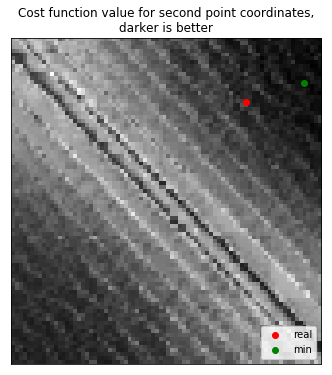

In [18]:
plt.figure(figsize=(6,6))
fig = plt.imshow(a, 'gray')
plt.title('Cost function value for second point coordinates,\ndarker is better')
plt.plot(points_real[0]*scale, points_real[1]*scale, 'ro')
plt.plot(r,c,'go')
plt.legend(['real','min'], loc='lower right')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('pic/optimization_useless_x{0}.png'.format(scale))
plt.show()

In [19]:
points_found = np.concatenate(([r/scale,c/scale], x2))#[(deg-1)*sz//deg-1, sz//deg, sz-1, sz-1]
print(points_found)
psf_found = bezier_psf2(points_found)

[18.75  2.75 20.   21.  ]


In [20]:
f([r/scale,c/scale]), f(points_real[:2])

(1.17134694029618e-05, 2.0645960306276552e-05)

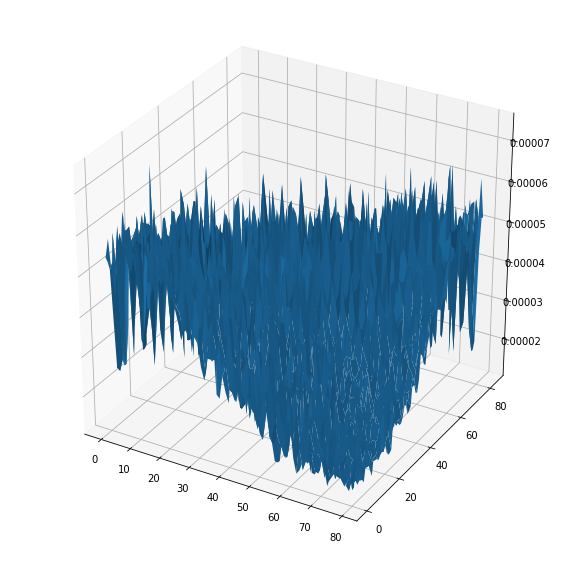

In [21]:
#%matplotlib notebook
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
X, Y = np.meshgrid(range(a.shape[1]),range(a.shape[0]))

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, a)
plt.show()

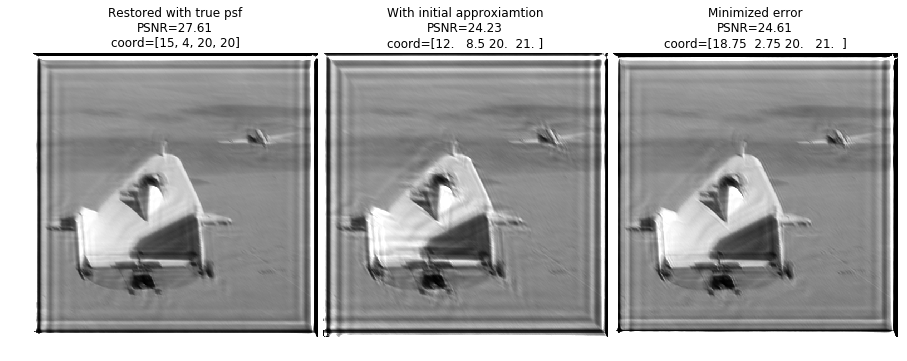

In [22]:
deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

#points_found = res_tnc['x']
#psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found)],
            savefig="pic/curved-grid.png")

In [23]:
#x0 = [12, 10, 20, 20]
res_nelder = minimize(partial(funcToMinimizeCurved2, I_blurred=lifting_bezier_blurred, xy2=x2, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
                      x0=x1, method='Nelder-Mead', options={'xtol': 1e-3, 'disp': True})
print(res_nelder)

Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 15
         Function evaluations: 46
 final_simplex: (array([[12.67148438,  8.46181641],
       [12.6709259 ,  8.46211472],
       [12.67059631,  8.46185532]]), array([3.8513806e-05, 3.8513806e-05, 3.8513806e-05]))
           fun: 3.85138059516145e-05
       message: 'Optimization terminated successfully.'
          nfev: 46
           nit: 15
        status: 0
       success: True
             x: array([12.67148438,  8.46181641])


In [24]:
x1, points_real

(array([12. ,  8.5]), [15, 4, 20, 20])

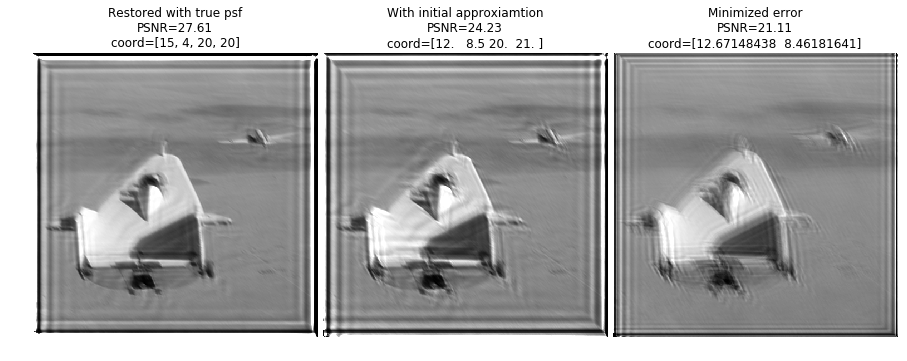

In [25]:
deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

points_found = res_nelder['x']
psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), res_nelder['x'])])

* Запустить градиентный метод
* Сделать мощный edgetaper
* Сделать антиалиасинг psf